# 1. Modelling the Environment

- Design a suitable representation for the robot's environment. Consider using a grid-based map where each cell represents a small area of the floor.
- Define states as specific grid cells that the robot can occupy.
- Identify possible actions the robot can take, such as moving forward, backward, turning left, or turning right (considering the robot's movement limitations).

In [ ]:
class Environment:

# Function to create the grid environment.
def __init__(self, width, height):
        self.width = width
        self.height = height
        self.grid = [[0 for _ in range(width)] for _ in range(height)]
        self.robot_x = None
        self.robot_y = None
        self.obstacles = []

# Function to set the  robot's position on the grid.
    def set_robot_position(self, x, y):
        if self.robot_x is not None and self.robot_y is not None:
            self.grid[self.robot_y][self.robot_x] = 0
        self.robot_x = x
        self.robot_y = y
        self.grid[self.robot_y][self.robot_x] = "R"

# Functions to add Obstacles, Cleaning Target, Charging Station and Robot to the environment. 
    def add_obstacle(self, x, y):
        self.obstacles.append((x, y))
        self.grid[y][x] = "O"
        
    def add_cleaning_target(self, x, y):
        self.grid[y][x] = "T"

    def add_charging_station(self, x, y):
        self.grid[y][x] = "C"

    def add_carpet(self, top_left_x, top_left_y, bottom_right_x, bottom_right_y):
        for y in range(top_left_y, bottom_right_y + 1):
            for x in range(top_left_x, bottom_right_x + 1):
                self.grid[y][x] = "W"

# Movement for Cleaning Robot
    def move_forward(self):
        if self.robot_y > 0 and self.grid[self.robot_y - 1][self.robot_x] != "O":
            self.set_robot_position(self.robot_x, self.robot_y - 1)

    def move_backward(self):
        if self.robot_y < self.height - 1 and self.grid[self.robot_y + 1][self.robot_x] != "O":
            self.set_robot_position(self.robot_x, self.robot_y + 1)

    def turn_left(self):
        if self.robot_x > 0 and self.grid[self.robot_y][self.robot_x - 1] != "O":
            self.set_robot_position(self.robot_x - 1, self.robot_y)

    def turn_right(self):
        if self.robot_x < self.width - 1 and self.grid[self.robot_y][self.robot_x + 1] != "O":
            self.set_robot_position(self.robot_x + 1, self.robot_y)

- *Environment* class represents the home environment of the cleaning robot.
- The *grid* attribute is a 2D list representing the floor plan of the room, where each element in the grid corresponds to one square meter of the floor. All cells are maked as empty(0).
- The methods *obstacle*, *cleaning_target* and *charging_station* are used to represent the obstacles to avoid, taget to clean and the charging station repectively.
- The methods *carpet* is used to represent the  carpet area, which requires more energy from the cleaning robot to traverse.
- You can create an instance of the Environment class with the desired width and height and then add obstacles, cleaning targets and charging stations as needed.

# 2. Cost Function and Heuristic

- Define a cost function that assigns a cost value to each action the robot takes. This could be a simple unit cost for each movement or consider factors like the type of terrain (carpet vs. hardwood) or energy expenditure for turns.
- Design a heuristic function h(x) that estimates the remaining distance for the robot to reach the cleaning target (represented by another specific grid cell). A simple option might be the Manhattan distance between the robot's current cell and the target cell, ignoring obstacles. However, explore a more sophisticated heuristic that considers the actual obstacles in the environment, penalising paths that would require the robot to navigate around them extensively.

In [31]:
# Cost Function
def cost_function(self, action):
    if action == "move_forward" or action == "move_backward":
        if self == "W":
            return 2 # Higher cost for moving on carpet
        elif self == 0:
            return 1 # Cost for moving on hardwood floor
        elif self == 1:
            return float('inf') #  Infinite cost for moving into an obstacle or wall - no movement possible
        return 1
    elif action == "turn_left" or action == "turn_right":
        return 0.5 # Cost for turning left or turning right

# Simple Heuristic Function
def simpleh(self, target_x, target_y):
    direct_to_target = abs(target_x - self.robot_x) + abs(target_y - self.robot_y)
    return  direct_to_target

# Advanced Heuristic Function
def advancedh(self, target_x, target_y):
    distance_to_target = abs(target_x - self.robot_x) + abs(target_y - self.robot_y) # Manhattan Distance from current position to target position
    obstacles = sum(row.count("O") for row in self.grid) # For cleaning robot to consider obstacles and walls
    distance_to_target -= obstacles # Subtract 1 for each obstacle encountered for the robot to avoid
    carpet_area = sum(row.count("w") for row in self.grid)
    distance_to_target -= carpet_area+2 # Add 2 to account for the fact that the robot is already on a carpet square
    return distance_to_target

#  3. A Implementation and Testing

- Implement the A* search algorithm to find the optimal path for the robot to navigate from its starting position to clean every cell in the environment and finally reach the charging station (another designated cell).
- Test your implementation on various environments with different obstacle layouts and target locations.
- Analyse the impact of the chosen heuristic function on the efficiency of the robot's path. Compare the path lengths and total costs with the simple Manhattan distance heuristic vs. the more sophisticated obstacle-aware heuristic.

In [32]:
from queue import PriorityQueue

# A Star Search Algorithm Class
class AStarSearch:
    # Initialize A Star Search object with the environment
    def __init__(self, environment):
        self.environment = environment
        
# Calculate Manhattan Distance from current position to target position IGNORING OBSTACLES
    def simpleh(self, target_x, target_y):
        direct_to_target = abs(target_x - self.robot_x) + abs(target_y - self.robot_y)
        return  direct_to_target

# Initialize priority queue
    def a_star_search(self, target_x, target_y):
        open_set = PriorityQueue()
        open_set.put((0, (self.environment.robot_x, self.environment.robot_y))) # Put the starting position in the open set with a priority of 0
        came_from = {} # Dictionary to store the path
        g_score = { (self.environment.robot_x, self.environment.robot_y): 0 } # Dictionary to store g scores

        # Loop until open set is empty
        while not open_set.empty():
            current = open_set.get()[1]

            if current[0] == target_x and current[1] == target_y:
                path = []

                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                return path[::-1]  # Reverse path to get from start to end

            # Iterate over possible movements: up, down, right, left
            for action in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                new_x, new_y = current[0] + action[0], current[1] + action[1]

                # Check if new position is within bounds
                if 0 <= new_x < self.environment.width and 0 <= new_y < self.environment.height:
                    tentative_g_score = g_score[current] + 1  # Cost of movement is 1

                    # Check if the new position has not been visited or the new path is better

                    if (new_x, new_y) not in g_score or tentative_g_score < g_score[(new_x, new_y)]:
                        came_from[(new_x, new_y)] = current # Update the path and g score for the new position
                        g_score[(new_x, new_y)] = tentative_g_score
                        f_score = tentative_g_score + self.heuristic(new_x, new_y, target_x, target_y)
                        open_set.put((f_score, (new_x, new_y)))  # Calculate the f score for the new position and add it to the open set

## 3.2 Envirnoments



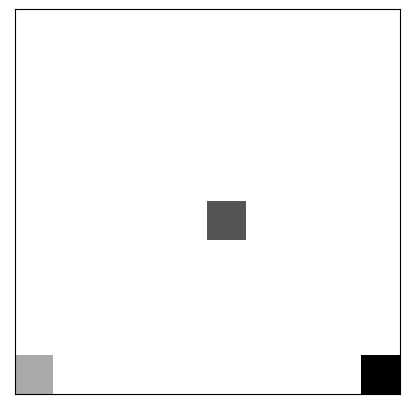

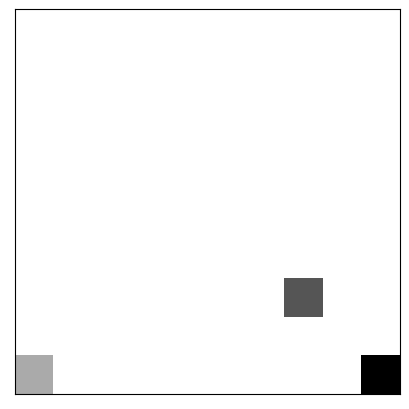

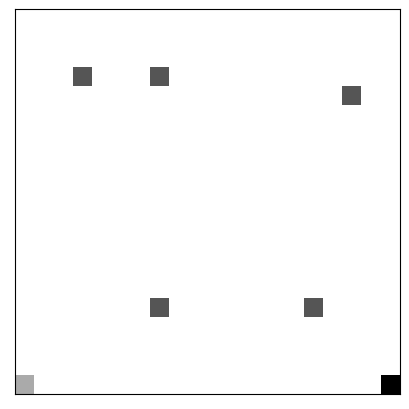

In [41]:
from queue import PriorityQueue
import matplotlib.pyplot as plt
import numpy as np


# Simple Environment
env1 = Environment(width=10, height=10)
env1.set_robot_position(0, 0)
env1.add_obstacle(5, 5)  # One obstacle
env1.add_cleaning_target(9, 9)  # Cleaning target
env1.add_charging_station(0, 9)  # Charging station

# Complex Environment
env2 = Environment(width=10, height=10)
env2.set_robot_position(0, 0)
env2.add_obstacle(3, 3)  # Obstacle 1
env2.add_obstacle(5, 2)  # Obstacle 2
env2.add_obstacle(7, 7)  # Obstacle 3
env2.add_cleaning_target(9, 9)  # Cleaning target
env2.add_charging_station(0, 9)  # Charging station
env2.add_carpet(2, 2, 6, 6)  # Carpeting

# Advanced Environment
env3 = Environment(width=20, height=20)
env3.set_robot_position(0, 0)
env3.add_obstacle(3, 3)  # Obstacle 1
env3.add_obstacle(5, 6)  # Obstacle 2
env3.add_obstacle(10, 10)  # Obstacle 3
env3.add_obstacle(15, 15)  # Obstacle 4
env3.add_obstacle(7, 15)  # Obstacle 5
env3.add_obstacle(12, 5)  # Obstacle 6
env3.add_obstacle(17, 4)  # Obstacle 7
env3.add_obstacle(7, 3)  # Obstacle 8
env3.add_cleaning_target(19, 19)  # Cleaning target
env3.add_charging_station(0, 19)  # Charging station
env3.add_carpet(5, 5, 14, 14)  # Carpeting

def visualize_environment(env):
    grid = np.array(env.grid)
    plt.figure(figsize=(5, 5))
    plt.imshow(np.where(grid == "O", 0.5, np.where(grid == "T", 0.25, np.where(grid == "C", 0.75, 1))), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Visualize the environments
visualize_environment(env1)
visualize_environment(env2)
visualize_environment(env3)

In [42]:
from queue import PriorityQueue
import matplotlib.pyplot as plt
import numpy as np

class Environment:
    def manhattan(self, target_x, target_y, obstacles):
        return abs(target_x - self.robot_x) + abs(target_y - self.robot_y) + len(obstacles)

    def a_star_search(self, target_x, target_y):
        frontier = PriorityQueue()
        start_node = (self.robot_x, self.robot_y, 0, [])
        frontier.put((0, start_node))
        explored = set()

        while not frontier.empty():
            _, node = frontier.get()
            x, y, cost_so_far, path = node

            if (x, y) == (target_x, target_y):
                return path

            if (x, y) in explored:
                continue

            explored.add((x, y))

            actions = ["move_forward", "move_backward", "turn_left", "turn_right"]

            for action in actions:
                new_cost = cost_so_far + self.cost(action)
                if action == "move_forward":
                    new_x, new_y = x, y - 1
                elif action == "move_backward":
                    new_x, new_y = x, y + 1
                elif action == "turn_left":
                    new_x, new_y = x - 1, y
                elif action == "turn_right":
                    new_x, new_y = x + 1, y

                if 0 <= new_x < self.width and 0 <= new_y < self.height and self.grid[new_y][new_x] != "O":
                    new_path = path + [action]
                    priority = new_cost + self.heuristic(target_x, target_y, new_path)
                    frontier.put((priority, (new_x, new_y, new_cost, new_path)))

        return None
    
